In [1]:
import pandas as pd
from datetime import datetime
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from seaborn import countplot

In [2]:
file_path = "C:\\Users\\Heath\\OneDrive\\Documents\\CS\\CS479\\FinalProject\\cleaned_crime_data_2021_modified_V1.csv"

# read csv into pandas dataframe
data = pd.read_csv(file_path)
data.head(10)

DR_NO        DATE.OCC  TIME.OCC    AREA.NAME  Vict.Age Vict.Sex  \
0  211607282  4/25/2021 0:00       300     Foothill        32        M   
1  210614453  7/13/2021 0:00      1525    Hollywood        49        M   
2  211115048  11/5/2021 0:00      1700    Northeast        30        M   
3  210811260  3/26/2021 0:00       930      West LA        56        F   
4  210906427   3/1/2021 0:00      1409     Van Nuys        27        F   
5  211218123  8/21/2021 0:00      2351  77th Street        51        F   
6  210117207  9/16/2021 0:00      1500      Central        24        M   
7  210909634  5/19/2021 0:00      1135     Van Nuys        52        M   
8  210807527  3/28/2021 0:00      1652      West LA        57        F   
9  211208132   3/5/2021 0:00       700  77th Street        45        F   

  Vict.Descent      LAT       LON  
0            H  34.2293 -118.3675  
1            W  34.1015 -118.3434  
2            H  34.0966 -118.2426  
3            O  34.0546 -118.3806  
4            B  34.1685 -118.4662  
5            B  33.9897 -118.2915  
6            B  34.0477 -118.2637  
7            W  34.1505 -118.4622  
8            O  34.0611 -118.4184  
9            H  33.9667 -118.2889

In [3]:
#drop driver's license, date occurence, area name columns as they will not be targeted.

#commented code below converts dates to numerical data types that represent date in nanoseconds from epoch
#data['DATE.OCC'] = data['DATE.OCC'].str.strip(' 0:00')
#def convertDateTime(date):
    #return datetime.strptime(date, '%m/%d/%Y').timestamp()
#data['DATE.OCC'] = data['DATE.OCC'].apply(convertDateTime)

data = data.drop(columns=['DATE.OCC','DR_NO','AREA.NAME'])
data.head(10)

TIME.OCC  Vict.Age Vict.Sex Vict.Descent      LAT       LON
0       300        32        M            H  34.2293 -118.3675
1      1525        49        M            W  34.1015 -118.3434
2      1700        30        M            H  34.0966 -118.2426
3       930        56        F            O  34.0546 -118.3806
4      1409        27        F            B  34.1685 -118.4662
5      2351        51        F            B  33.9897 -118.2915
6      1500        24        M            B  34.0477 -118.2637
7      1135        52        M            W  34.1505 -118.4622
8      1652        57        F            O  34.0611 -118.4184
9       700        45        F            H  33.9667 -118.2889

In [5]:
#In this current state, not all data is machine readable.
#Vict.Sex and Vict.Descent both need to be converted to a machine readable format.
#We will use one-hot encoding to do this.
#Before we can encode, we will to reduce the number of categories for both Vict.Sex and Vict.Descent
#This is done because a majority of the categories aren't used and will only complicate things later on if they aren't removed
#As seen in our EDA:
    #the 'H' category only occurs 28 times in Vict.Sex, so we will discard it to reduce the dimensions of our one-hot vectors
    #over 90% of the Vict.Descent data lies in 5 descents, the rest we can discard to reduce the dimensions further

#Remove any rows with H in their Vict.Sex column
cleaned = data.drop(data[data['Vict.Sex']=='H'].index)

#Remove any rows without the specified characters below in their Vict.Descent column
toKeep = ['B','H','O','W','X']
cleaned = cleaned.drop(cleaned[cleaned['Vict.Descent'].isin(toKeep)==False].index)
cleaned.head(10)
#the table printed now only stores records with the most meaningful data

TIME.OCC  Vict.Age Vict.Sex Vict.Descent      LAT       LON
0       300        32        M            H  34.2293 -118.3675
1      1525        49        M            W  34.1015 -118.3434
2      1700        30        M            H  34.0966 -118.2426
3       930        56        F            O  34.0546 -118.3806
4      1409        27        F            B  34.1685 -118.4662
5      2351        51        F            B  33.9897 -118.2915
6      1500        24        M            B  34.0477 -118.2637
7      1135        52        M            W  34.1505 -118.4622
8      1652        57        F            O  34.0611 -118.4184
9       700        45        F            H  33.9667 -118.2889

In [6]:
#here, we will implement Kmodes (similar to KMeans, but clusters categorical variables rather than numerical). 
#to do this, for now, we will strip the date and loc (lat, lon) data. What's left is our categorical data
#but we will categorize age data in ranges (10-20, 21-30, 31-40, etc.) as well as time data

KmodesData = pd.DataFrame.copy(cleaned)
KmodesData.head()
KmodesData.drop(columns=['LAT', 'LON'], inplace=True)

#group ages
KmodesData['AgeBins'] = pd.cut(KmodesData['Vict.Age'], bins=[0,20,30,40,50,60,70,80,max(KmodesData['Vict.Age'])])
KmodesData.drop(columns=['Vict.Age'], inplace=True)

#group times
KmodesData['TimeOccBins'] = pd.cut(KmodesData['TIME.OCC'], bins=[0, 600, 1200, 1600, 2100, 2400])
KmodesData.drop(columns=['TIME.OCC'], inplace=True)

#convert it all to strings to ensure categories can be determined by KModes (this may be unnecssary, just want to be safe)
KmodesData = KmodesData.astype('str', copy=True)
KmodesData.head(10)

Vict.Sex Vict.Descent   AgeBins   TimeOccBins
0        M            H  (30, 40]      (0, 600]
1        M            W  (40, 50]  (1200, 1600]
2        M            H  (20, 30]  (1600, 2100]
3        F            O  (50, 60]   (600, 1200]
4        F            B  (20, 30]  (1200, 1600]
5        F            B  (50, 60]  (2100, 2400]
6        M            B  (20, 30]  (1200, 1600]
7        M            W  (50, 60]   (600, 1200]
8        F            O  (50, 60]  (1600, 2100]
9        F            H  (40, 50]   (600, 1200]

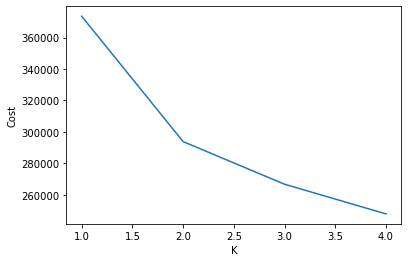

In [35]:
#Kmodes requires us to give it the number of clusters we wish to categorize
#we will use the Elbow method to determine this number of clusters K

cost = []
K = [1,2,3,4]
for i in K:
    kout = KModes(n_clusters=i, init='Cao', n_init=4)
    kout.fit_predict(KmodesData)
    cost.append(kout.cost_)
plt.plot(K, cost)
plt.xlabel('K')
plt.ylabel('Cost')
plt.show()

#we will select the farthest right bend as possible...
#we can see the bend at K=2, so we will use 2 clusters
#it also makes sense to use 2 clusters as we have a feature (Gender) that has two primary categories

In [7]:
#we will now implement oiur KModes algo
kout = KModes(n_clusters=2, init='Cao', n_init=4)

#and use the fitted model to assign clusters to each victim
clusters = kout.fit_predict(KmodesData)

#finally append the cluster values to our dataframe
KmodesData['Cluster'] = clusters
#KmodesData.head(10)

#make copy of of this data and add lat and long back to it. We will use this dataframe
#for further data analysis
csv = pd.DataFrame.copy(cleaned)
csv['Cluster'] = clusters
path = "C:\\Users\\Heath\\OneDrive\\Documents\\CS\\CS479\\FinalProject\\clustered.csv" 
csv.to_csv(path)
KmodesData.head(10)

Vict.Sex Vict.Descent   AgeBins   TimeOccBins  Cluster
0        M            H  (30, 40]      (0, 600]        0
1        M            W  (40, 50]  (1200, 1600]        0
2        M            H  (20, 30]  (1600, 2100]        0
3        F            O  (50, 60]   (600, 1200]        1
4        F            B  (20, 30]  (1200, 1600]        1
5        F            B  (50, 60]  (2100, 2400]        1
6        M            B  (20, 30]  (1200, 1600]        0
7        M            W  (50, 60]   (600, 1200]        1
8        F            O  (50, 60]  (1600, 2100]        0
9        F            H  (40, 50]   (600, 1200]        1

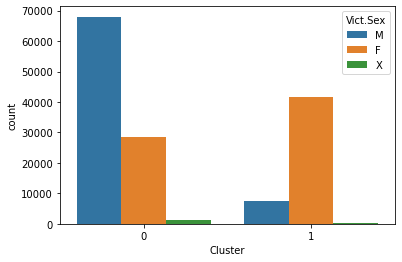

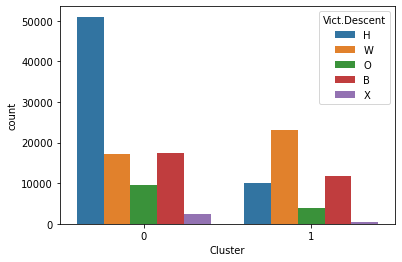

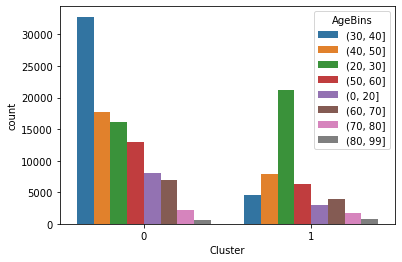

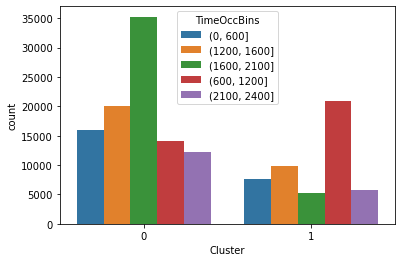

In [78]:
#here, we will use countplots to visualize each feature's counts.
#again, we have two clusters so that is represented on the X axis with counts on the Y axis
#think of each cluster being a sample victim that is targeted most frequently
#we can see in the Vict.Sex plot, that cluster 0 is the males cluster and cluster 1 is the females cluster
#Looking at the rest of the diagrams, we can essentially determine the most commonly victimized male (0) and female (1)
#using these clusters, we can pick the largest value in each plot to "build" an at-risk victim profile

#Victim 1 (culster 0): Male, Hispanic, 30-40 years old, attacked between 4:00pm and 9:00pm
#Victim 2 (cluster 1): Female, White, 20-30 years old, attackd between 6:00am and 12:00pm
#We can say people with these characteristics are most likely to be attacked in LA

#we can add location data to give a potential area where they may be attacked.
#to do this, we will need to convert the lat and lon data to categorical data
#or use k-prototypes that allows for both numerical and categorical data features

for column in KmodesData.iloc[:,:-1]:
    plt.subplots()
    countplot(x='Cluster', hue=column, data=KmodesData)
    plt.show()